In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

2022-11-24 14:04:15.120592: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-24 14:04:25.837453: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-24 14:04:26.913422: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [2]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import moscot
from moscot.problems.time import TemporalProblem
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from muon import atac as ac
import numpy as np
import itertools
import pandas as pd

2022-11-24 14:05:43.151173: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-24 14:05:43.151377: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
adata = sc.read_h5ad("/lustre/groups/ml01/workspace/moscot_paper/pancreas/pancreas_multiome_2022_processed.h5ad")

In [4]:
adata.obs['time'] = adata.obs.apply(lambda x: 14.5 if x["sample"]=="E14.5" else 15.5, axis=1)

In [5]:
marginals = pd.read_csv("marginals.csv", index_col="Unnamed: 0")
adata.obs["a"] = marginals

In [6]:
adata_gex = adata[:, adata.var["modality"]=="GEX"].copy()
adata_atac = adata[:, adata.var["modality"]=="ATAC"].copy()

# LSI ATAC space

In [7]:
ac.pp.tfidf(adata_atac, scale_factor=1e4)

In [8]:
sc.pp.normalize_per_cell(adata_atac, counts_per_cell_after=1e4)
sc.pp.log1p(adata_atac)

In [9]:
ac.tl.lsi(adata_atac, n_comps=15)

In [10]:
depth_corr = [np.corrcoef(adata_atac.obsm["X_lsi"][:,i], adata_atac.obs["nCount_ATAC"])[1,0] for i in range(adata_atac.obsm["X_lsi"].shape[1])]

In [11]:
comps_to_remove = np.where(np.abs(depth_corr) > 0.4)[0]
comps_to_remove

array([0, 4])

In [12]:
subset = list(set(range(adata_atac.obsm["X_lsi"].shape[1])) - set(comps_to_remove))

In [13]:
adata_atac.obsm['X_lsi'] = adata_atac.obsm['X_lsi'][:,subset]

# PCA GEX space

In [14]:
sc.pp.normalize_total(adata_gex, target_sum=1e4)
sc.pp.log1p(adata_gex)

In [15]:
sc.pp.pca(adata_gex, n_comps=15)

In [16]:
adata_gex.obsm["X_pca_scaled"] = StandardScaler().fit_transform(adata_gex.obsm["X_pca"])

# Concatenate

In [17]:
adata.obsm["X_joint"] = np.concatenate((adata_gex.obsm["X_pca_scaled"], adata_atac.obsm["X_lsi"]), axis=1)

In [18]:
tp0 = TemporalProblem(adata)
tp0 = tp0.prepare("time", joint_attr="X_joint", a="a")
tp0 = tp0.solve(epsilon=1e-4, tau_a=0.95, tau_b=0.99, max_iterations=1e8)

INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(9811, 7107)].            


In [19]:
tp_desc = tp0.cell_transition(14.5, 15.5, "celltype", "celltype", forward=True)

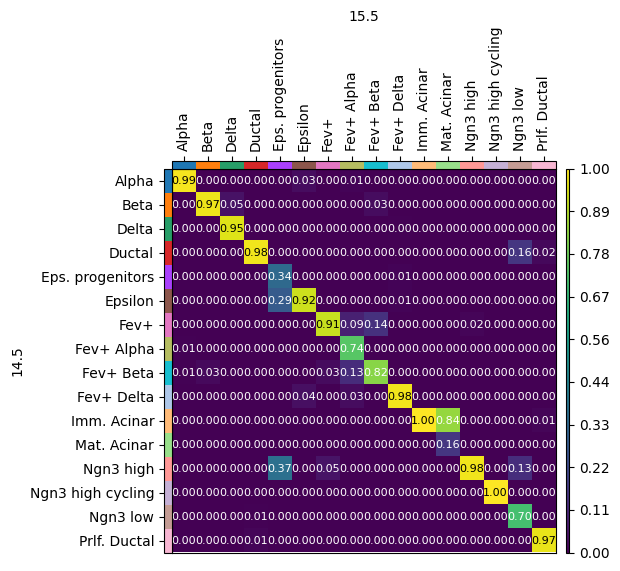

In [26]:
import moscot.plotting as mpl
mpl.cell_transition(tp0, dpi=100, fontsize=8)

In [27]:
tp_anc = tp0.cell_transition(14.5, 15.5, "celltype", "celltype", forward=False)

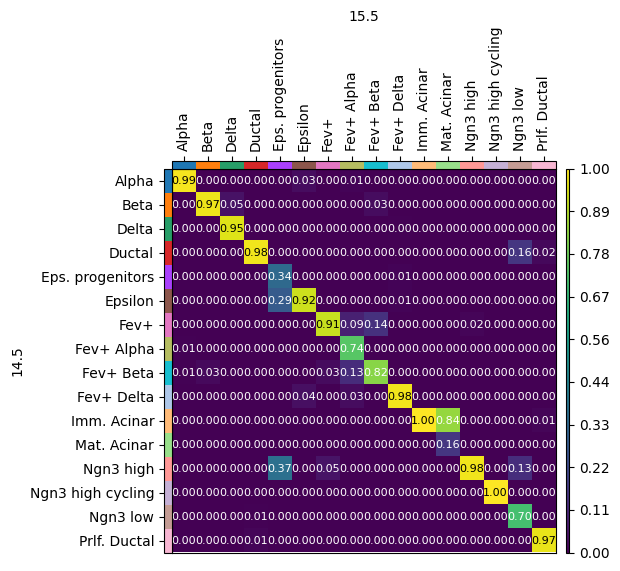

In [28]:
mpl.cell_transition(tp0, dpi=100, fontsize=8)

In [29]:
tp0 = TemporalProblem(adata)
tp0 = tp0.prepare("time", joint_attr="X_joint", a="a")
tp0 = tp0.solve(epsilon=1e-4, tau_a=0.99, tau_b=0.999, max_iterations=1e8)

INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(9811, 7107)].            


In [ ]:
tp_desc = tp0.cell_transition(14.5, 15.5, "celltype", "celltype", forward=True)

In [ ]:
mpl.cell_transition(tp0, dpi=100, fontsize=8)